## 신기술 R&D 논문 탐색 자동화를 통한 미래기술 예측 모듈 개발(PoC)

![](./images/concep1.png)


In [1]:
import os
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.word2vec import Word2Vec
import nltk
import time
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from eunjeon import Mecab

# %appdata%\nltk_data\corpora\stopwords
# korean 파일을 생성하여 복사함
from nltk.corpus import stopwords 
nltk.download('stopwords')

np.random.seed(42)

mecab = Mecab('C://mecab//mecabrc')

# 한글깨짐 방지를 위한 글꼴 설정
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milly\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### 1. 통합된 원본 데이터 파일을 읽어온다

In [2]:
# RPA로부터 수집된 "자동차" 관련 50568개의 논문 데이터 셋을 로드함

ROOT_DIR = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
dataset = pd.read_csv(os.path.join(ROOT_DIR, "dataset/articles.csv"))
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50568 entries, 0 to 50567
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   제목                              50568 non-null  object 
 1   저자                              50568 non-null  object 
 2   발행기관                            50568 non-null  object 
 3   학술지명                            50568 non-null  object 
 4   권호사항                            50568 non-null  object 
 5   발행연도                            50568 non-null  int64  
 6   작성언어                            50568 non-null  object 
 7   주제어                             26933 non-null  object 
 8   KDC                             11761 non-null  float64
 9   등재정보                            13083 non-null  object 
 10  자료형태                            50568 non-null  object 
 11  발행기관 URL                        22715 non-null  object 
 12  수록면                             

In [3]:
dataset.head()

제목  \
0                       전기 이륜자동차 분류기준 현황 : 자동차관리법 중심   
1             자동차 사회의 환경과 에너지 문제 = 자동차 엔진 기술의 역사적 동향   
2  수소 연료전지 자동차의 충돌 및 화재안전성 관련 연구동향 = Trends on Cr...   
3  차세대 자동차 개발의 Plastic Hood 설계 및 CAE해석 = Plastic ...   
4  자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...   

                                                  저자      발행기관  \
0                                                정윤재  한국자동차공학회   
1                                  김영길(Yong Kil Kim)  한국자동차공학회   
2  임재문(Jae Moon Lim),장형진(Hyung Jin Chang),김규현(Gyu...  한국자동차공학회   
3  황태원(Taewon Hwang),최치훈(Chihoon Choi),박상선(Sangsu...  한국자동차공학회   
4                                황경수(Kyungsoo Whang)  한국자동차공학회   

                     학술지명                     권호사항  발행연도    작성언어  \
0       한국자동차공학회 Workshop   Vol.2011No.9[2011]\r\n  2011  Korean   
1     한국자동차공학회 학술대회 및 전시회  Vol.2014No.11[2014]\r\n  2014  Korean   
2  한국자동차공학회 춘 추계 학술대회 논문집      Vol.-No.-[2008]\r\n  2008  Korean   
3  한국자동차공학회 춘 추계 학술대회 논문집      Vol.-No.-[2006]\r\n  2006  Korean   
4       한국자동차공학회 Workshop   Vol.2001No.-[2001]\r\n  2001  Korean   

                                                 주제어    KDC 등재정보  ...  \
0                                                NaN  556.0  NaN  ...   
1  Internal Combustion Engine(내연기관),Energy (에너지),...    NaN  NaN  ...   
2  Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...    NaN  NaN  ...   
3  HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...    NaN  NaN  ...   
4                                                NaN    NaN  NaN  ...   

              발행기관 URL        수록면 KCI 피인용횟수  비고  중단사유     제공처 소장기관  \
0  http://www.ksae.org       1-14       NaN NaN   NaN   DBpia  NaN   
1                  NaN  1477-1477       NaN NaN   NaN   DBpia  NaN   
2  http://www.ksae.org  1253-1258       NaN NaN   NaN   DBpia  NaN   
3  http://www.ksae.org  2032-2032       NaN NaN   NaN   DBpia  NaN   
4  http://www.ksae.org      70-80       NaN NaN   NaN   DBpia  NaN   

                                    국문 초록 (Abstract)  \
0                                                NaN   
1                                                NaN   
2  환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...   
3  현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다. 발전사를 살펴보면...   
4  오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...   

                      다국어 초록 (Multilingual Abstract)  \
0                                                NaN   
1                                                NaN   
2  The researches on the crash and the fire safet...   
3                                                NaN   
4                                                NaN   

                                                  목차  
0                                                NaN  
1                                                NaN  
2  Abstract\n1. 서론\n2. 수소의 특성\n3. 충돌 및 화재안전성 관련 연...  
3                                                NaN  
4  초록<br/>\n1.서론<br/>\n2.국내 자동차기술교육의 역사<br/>\n3.민...  

[5 rows x 21 columns]

## Word2Vec을 활용한 주제어간 연간성 분석


In [86]:
train_data = dataset.loc[:, ['제목', '저자', '학술지명', '발행연도', '주제어', '국문 초록 (Abstract)']]
train_data['주제어or제목'] = np.where(train_data['주제어'].isna(), train_data['제목'], train_data['주제어'])
train_data.head()

제목  \
0                       전기 이륜자동차 분류기준 현황 : 자동차관리법 중심   
1             자동차 사회의 환경과 에너지 문제 = 자동차 엔진 기술의 역사적 동향   
2  수소 연료전지 자동차의 충돌 및 화재안전성 관련 연구동향 = Trends on Cr...   
3  차세대 자동차 개발의 Plastic Hood 설계 및 CAE해석 = Plastic ...   
4  자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...   

                                                  저자                    학술지명  \
0                                                정윤재       한국자동차공학회 Workshop   
1                                  김영길(Yong Kil Kim)     한국자동차공학회 학술대회 및 전시회   
2  임재문(Jae Moon Lim),장형진(Hyung Jin Chang),김규현(Gyu...  한국자동차공학회 춘 추계 학술대회 논문집   
3  황태원(Taewon Hwang),최치훈(Chihoon Choi),박상선(Sangsu...  한국자동차공학회 춘 추계 학술대회 논문집   
4                                황경수(Kyungsoo Whang)       한국자동차공학회 Workshop   

   발행연도                                                주제어  \
0  2011                                                NaN   
1  2014  Internal Combustion Engine(내연기관),Energy (에너지),...   
2  2008  Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...   
3  2006  HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...   
4  2001                                                NaN   

                                    국문 초록 (Abstract)  \
0                                                NaN   
1                                                NaN   
2  환경문제에 따른 배기가스 배출저감 및 자원고갈에 따른 대안으로 향후 수소 연료전지 ...   
3  현재 생활 필수품 중의 하나인 자동차논 많은 변화를 보이고 있다. 발전사를 살펴보면...   
4  오늘날 급속히 변화하고 있는 자동차 기술에 대응한 자동차 기술교육의 방법을 모색하여...   

                                             주제어or제목  
0                       전기 이륜자동차 분류기준 현황 : 자동차관리법 중심  
1  Internal Combustion Engine(내연기관),Energy (에너지),...  
2  Hydrogen Fuel Cell Vehicle(수소 연료전지 자동차),Crash ...  
3  HOOD(본넷트),Distance(이동량),LS-DYNA(구조해석),MOLDFLOW...  
4  자동차 산업의 역사와 급변하는 기술에 대응한 교육의 바람직한 방향에 관한 연구 = ...

### 연도별 WORD2VEC 모델 만들기


In [5]:
stop_words = stopwords.words('korean') + stopwords.words('english')
print(f'stop word: {len(stop_words)} 개')

def get_tokenized_data(rawdata) :
    tokenized_data = []
    pos=["NNG","NNP"]

    start = time.time()
    for data in rawdata :
        if  pd.notna(data) :
            temp_X = [word for word, tag in mecab.pos(data) if len(word) > 1 and tag in pos and word not in stop_words]
            tokenized_data.append(temp_X)

    end = time.time()
    print(f'데이터개수:{len(rawdata)}, 총 소요시간:{end-start}초')

    return tokenized_data

stop word: 319 개


In [6]:
p_year = [[2012, 2013, 2014], [2015, 2016, 2017], [2018, 2019, 2020]]

In [103]:
for year in p_year:
    data_name = "주제어"
    tokenized_data = get_tokenized_data(train_data[train_data['발행연도'].isin(year)][data_name])
    model = Word2Vec(size=300, window=2, min_count=3, workers=4, sg=0, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=3, hs=1)
    model.build_vocab(tokenized_data, progress_per=10000)
    model.train(sentences=tokenized_data, total_examples=model.corpus_count, epochs=43, report_delay=1)
    model.save(f"./model/{year[0]}-{year[-1]}-{data_name}.model")

er thread finished; awaiting finish of 1 more threads
INFO - 13:36:37: worker thread finished; awaiting finish of 0 more threads
INFO - 13:36:37: EPOCH - 43 : training on 25102 raw words (3836 effective words) took 0.0s, 193559 effective words/s
INFO - 13:36:37: training on a 1079386 raw words (166705 effective words) took 1.4s, 116097 effective words/s
INFO - 13:36:37: saving Word2Vec object under ./model/2015-2017-주제어.model, separately None
INFO - 13:36:37: not storing attribute vectors_norm
INFO - 13:36:37: not storing attribute cum_table
INFO - 13:36:37: saved ./model/2015-2017-주제어.model
INFO - 13:36:38: collecting all words and their counts
INFO - 13:36:38: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:36:38: collected 13004 word types from a corpus of 22967 raw words and 5261 sentences
INFO - 13:36:38: Loading a fresh vocabulary
INFO - 13:36:38: effective_min_count=3 retains 1394 unique words (10% of original 13004, drops 11610)
INFO - 13:36:38: effe

In [8]:
for year in p_year:
    data_name = "주제어or제목"
    tokenized_data = get_tokenized_data(train_data[train_data['발행연도'].isin(year)][data_name])
    model = Word2Vec(size=300, window=2, min_count=3, workers=4, sg=0, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=3, hs=1)
    model.build_vocab(tokenized_data, progress_per=10000)
    model.train(sentences=tokenized_data, total_examples=model.corpus_count, epochs=43, report_delay=1)
    model.save(f"./model/{year[0]}-{year[-1]}-{data_name}.model")        

 awaiting finish of 1 more threads
INFO - 12:05:28: worker thread finished; awaiting finish of 0 more threads
INFO - 12:05:28: EPOCH - 43 : training on 35610 raw words (8840 effective words) took 0.0s, 252459 effective words/s
INFO - 12:05:28: training on a 1531230 raw words (378423 effective words) took 2.2s, 169603 effective words/s
INFO - 12:05:28: saving Word2Vec object under ./model/2015-2017-주제어or제목.model, separately None
INFO - 12:05:28: not storing attribute vectors_norm
INFO - 12:05:28: not storing attribute cum_table
INFO - 12:05:29: saved ./model/2015-2017-주제어or제목.model
INFO - 12:05:29: collecting all words and their counts
INFO - 12:05:29: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:05:29: collected 14469 word types from a corpus of 30691 raw words and 6587 sentences
INFO - 12:05:29: Loading a fresh vocabulary
INFO - 12:05:29: effective_min_count=3 retains 1900 unique words (13% of original 14469, drops 12569)
INFO - 12:05:29: effective_min_c

In [12]:
for year in p_year:
    data_name = "국문 초록 (Abstract)"
    tokenized_data = get_tokenized_data(train_data[train_data['발행연도'].isin(year)][data_name])
    model = Word2Vec(size=300, window=2, min_count=20, workers=4, sg=0, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, hs=1)
    model.build_vocab(tokenized_data, progress_per=10000)
    model.train(sentences=tokenized_data, total_examples=model.corpus_count, epochs=43, report_delay=1)
    model.save(f"./model/{year[0]}-{year[-1]}-{data_name.replace(' ', '')}.model")

POCH - 43 : training on 238789 raw words (70423 effective words) took 0.3s, 217057 effective words/s
INFO - 12:08:19: training on a 10267927 raw words (3027533 effective words) took 14.7s, 206388 effective words/s
INFO - 12:08:19: saving Word2Vec object under ./model/2015-2017-국문초록(Abstract).model, separately None
INFO - 12:08:19: not storing attribute vectors_norm
INFO - 12:08:19: not storing attribute cum_table
INFO - 12:08:19: saved ./model/2015-2017-국문초록(Abstract).model
INFO - 12:08:23: collecting all words and their counts
INFO - 12:08:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:08:23: collected 15629 word types from a corpus of 183995 raw words and 1795 sentences
INFO - 12:08:23: Loading a fresh vocabulary
INFO - 12:08:23: effective_min_count=20 retains 1481 unique words (9% of original 15629, drops 14148)
INFO - 12:08:23: effective_min_count=20 leaves 137468 word corpus (74% of original 183995, drops 46527)
INFO - 12:08:23: deleting the raw co

In [14]:
model1 = Word2Vec.load("./model/2012-2014-주제어.model")
model2 = Word2Vec.load("./model/2015-2017-주제어.model")
model3 = Word2Vec.load("./model/2018-2020-주제어.model")

INFO - 12:43:58: loading Word2Vec object from ./model/2012-2014-주제어.model
INFO - 12:43:58: loading wv recursively from ./model/2012-2014-주제어.model.wv.* with mmap=None
INFO - 12:43:58: setting ignored attribute vectors_norm to None
INFO - 12:43:58: loading vocabulary recursively from ./model/2012-2014-주제어.model.vocabulary.* with mmap=None
INFO - 12:43:58: loading trainables recursively from ./model/2012-2014-주제어.model.trainables.* with mmap=None
INFO - 12:43:58: setting ignored attribute cum_table to None
INFO - 12:43:58: loaded ./model/2012-2014-주제어.model
INFO - 12:43:58: loading Word2Vec object from ./model/2015-2017-주제어.model
INFO - 12:43:58: loading wv recursively from ./model/2015-2017-주제어.model.wv.* with mmap=None
INFO - 12:43:58: setting ignored attribute vectors_norm to None
INFO - 12:43:58: loading vocabulary recursively from ./model/2015-2017-주제어.model.vocabulary.* with mmap=None
INFO - 12:43:58: loading trainables recursively from ./model/2015-2017-주제어.model.trainables.* with

In [15]:
print(model1.wv.most_similar("자율주행"), end="\n\n")
print(model2.wv.most_similar("자율주행"), end="\n\n")
print(model3.wv.most_similar("자율주행"), end="\n\n")

INFO - 12:44:01: precomputing L2-norms of word weight vectors
INFO - 12:44:01: precomputing L2-norms of word weight vectors
INFO - 12:44:01: precomputing L2-norms of word weight vectors
[('격납시트', 0.9846287965774536), ('신교통시스템', 0.9811715483665466), ('클러치', 0.9764189124107361), ('소형 승용차량', 0.976138174533844), ('음압', 0.9760701656341553), ('레디어스 로드', 0.974061131477356), ('풍동 시험', 0.9734950065612793), ('하이트 모터', 0.9703666567802429), ('프리이그니션', 0.9663669466972351), ('안락감', 0.9612646698951721)]

[('인공지능', 0.9615708589553833), ('발전기', 0.9587689638137817), ('비도로용디젤엔진', 0.9569519758224487), ('최적 제어', 0.9559874534606934), ('복제', 0.9555600881576538), ('후방향 시뮬레이션', 0.9380691647529602), ('입자개수', 0.9365984201431274), ('폴리우레탄', 0.932563304901123), ('인증', 0.9318394064903259), ('위상최적화', 0.9302624464035034)]

[('용접', 0.9638109803199768), ('솔레노이드 밸브', 0.9553760886192322), ('정보', 0.9530841708183289), ('토크 벡터링', 0.9464203119277954), ('최적화', 0.9427674412727356), ('알루미늄합금', 0.9410648345947266), ('제어로직', 0.93

In [16]:
model3.wv.vectors.shape

(1394, 300)

In [17]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20 ,20))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

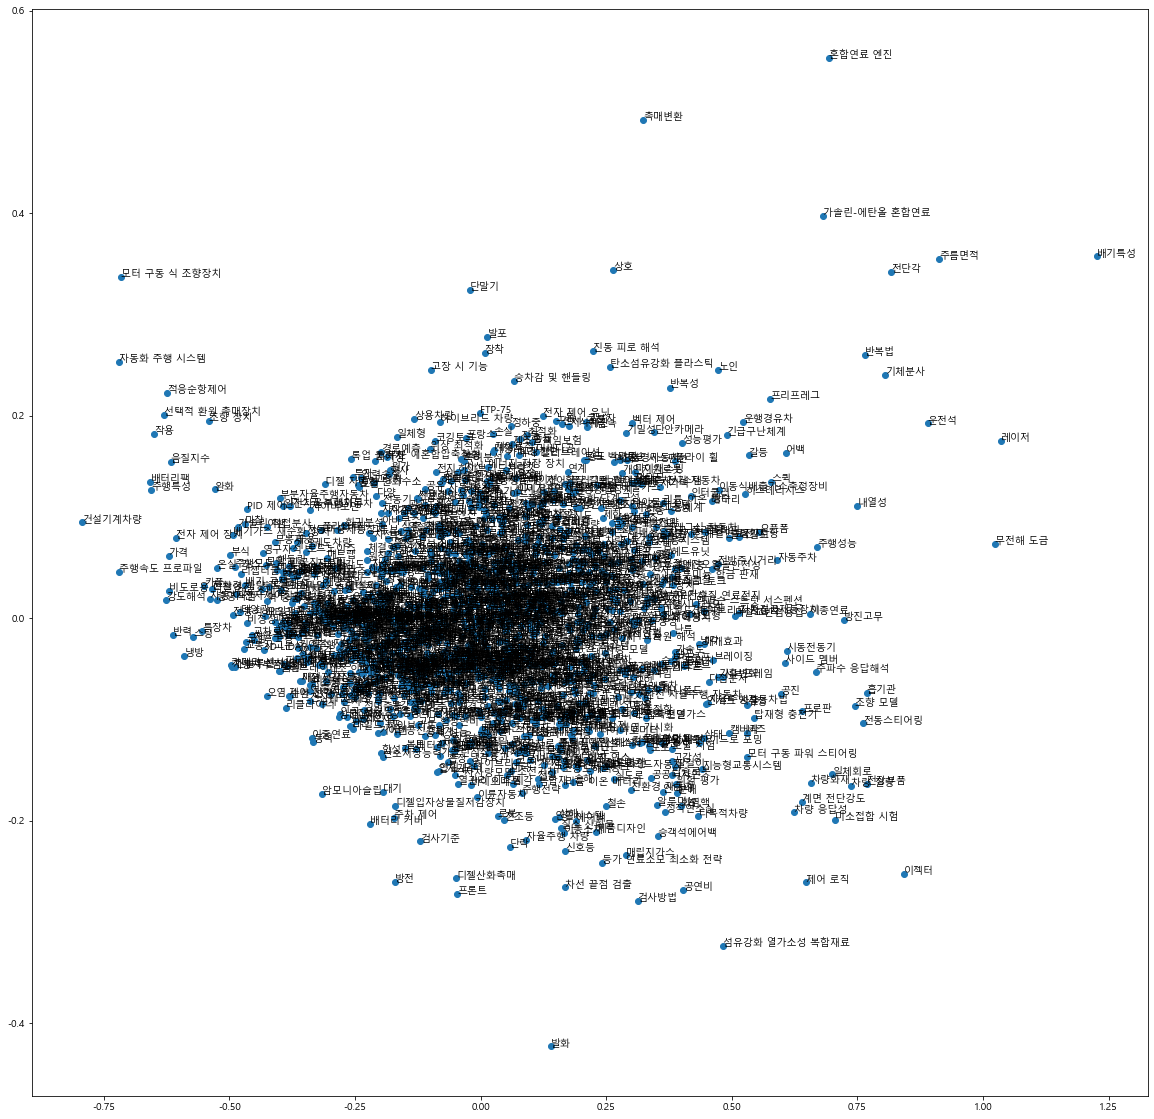

In [18]:
word_vectors = model3.wv

vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

plot_2d_graph(vocabs, xs, ys)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1394 samples in 0.061s...
[t-SNE] Computed neighbors for 1394 samples in 0.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1394
[t-SNE] Computed conditional probabilities for sample 1394 / 1394
[t-SNE] Mean sigma: 0.041407
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.252533
[t-SNE] KL divergence after 8450 iterations: 0.813947


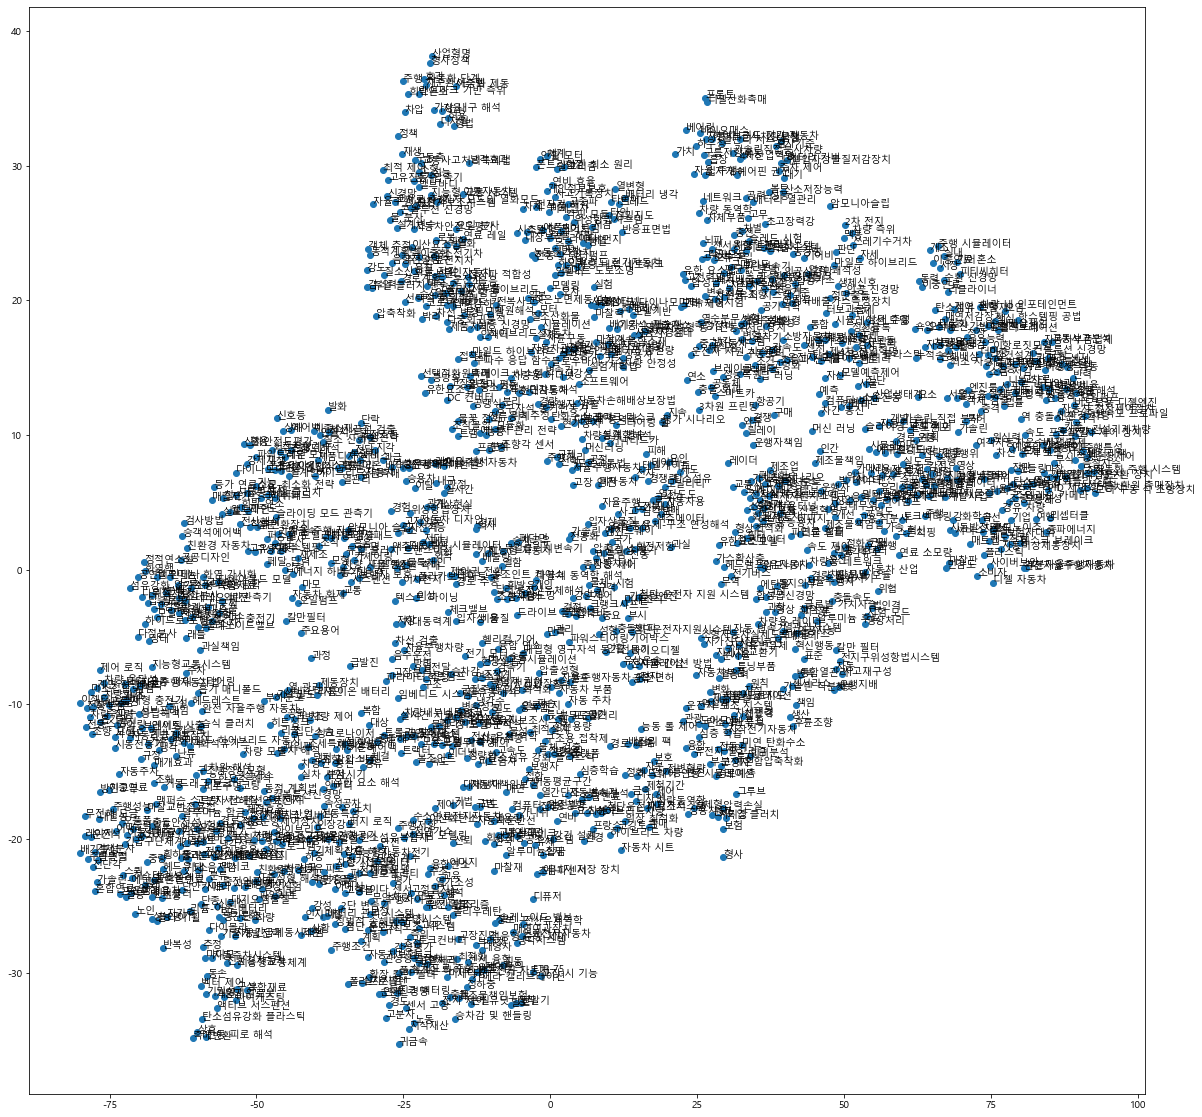

In [23]:
#T-SNE 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

#model3(2018-2020-주제어.model) 사용
word_vectors = model3.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

Z = tsne.fit_transform(word_vectors_list)

plt.figure(figsize=(20, 20))
plt.scatter(Z[:,0], Z[:,1])

#점에 text 붙히기
for i, v in enumerate(vocabs):
    plt.annotate(s=v, xy=(Z[i,0], Z[i,1]))
plt.draw()
plt.savefig('./images/tsne.png', dpi=300)

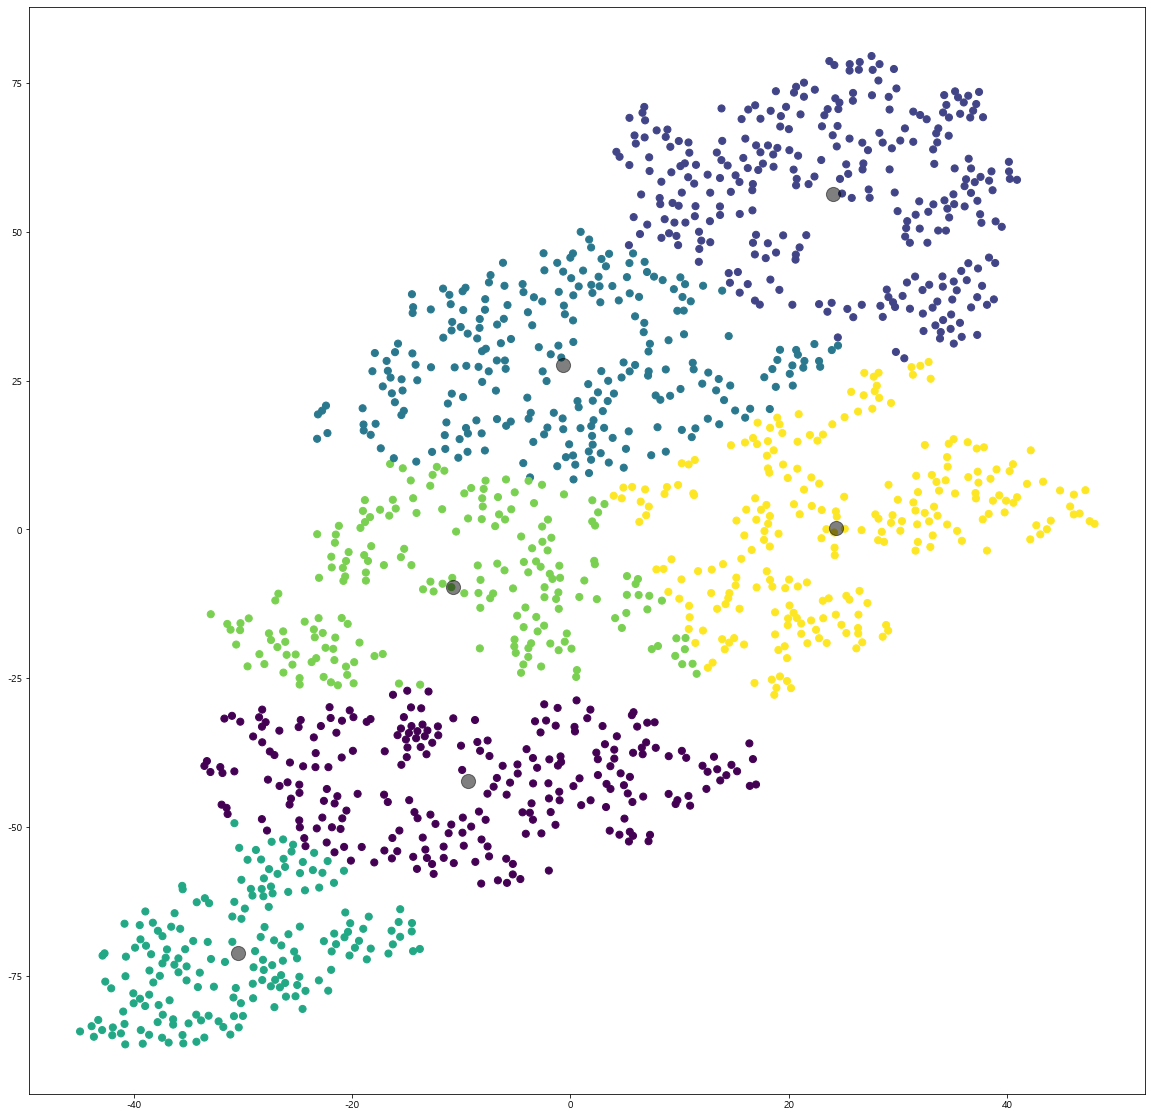

In [22]:
#T-SNE 결과를 K-Means 클러스터링으로 분류
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6).fit(Z)
y_kmeans = kmeans.predict(Z)
centers = kmeans.cluster_centers_

plt.figure(figsize=(20, 20))

plt.scatter(Z[:,0], Z[:,1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.draw()
plt.savefig('./images/kmeans_clustering.png', dpi=300)

#plt.figure(figsize=(20, 20))

In [45]:
del model1
del model2
del model3

### 1. 주제어 추천 및 관련논문(초록) 제시

In [104]:
#저장된 모델 로딩
del model
model = Word2Vec.load("./model/2018-2020-주제어.model")

INFO - 13:36:52: loading Word2Vec object from ./model/2018-2020-주제어.model
INFO - 13:36:52: loading wv recursively from ./model/2018-2020-주제어.model.wv.* with mmap=None
INFO - 13:36:52: setting ignored attribute vectors_norm to None
INFO - 13:36:52: loading vocabulary recursively from ./model/2018-2020-주제어.model.vocabulary.* with mmap=None
INFO - 13:36:52: loading trainables recursively from ./model/2018-2020-주제어.model.trainables.* with mmap=None
INFO - 13:36:52: setting ignored attribute cum_table to None
INFO - 13:36:52: loaded ./model/2018-2020-주제어.model


In [105]:
keyword = "자율주행"

In [106]:
#주제어 추천
def find_keyword(word) :
    try :
        result = model.wv.most_similar(keyword, topn=10)
        return [x[0] for x in result]
    except :
        return ('없는 단어 입니다.')
    

In [129]:
#최신순으로 상위 10개의 논문 제시
def find_article(word) :
    keywords = find_keyword(word)
    data = train_data[train_data['주제어'].notna() & train_data['주제어'].str.contains('|'.join(keywords))].sort_values(by=['발행연도'], axis=0, ascending=False)[:10]
    data = list(data.loc[:, ['제목', '저자']].to_records(index=False))
    
    for i, v in enumerate(data) :
        print(f'{i+1} 번째 논문')
        print(f'\t제목: {v[0]}')
        print(f'\t저자: {v[1].split(",")[0]}')

In [130]:
#주제어 추천
find_keyword(keyword)

['경로 예측',
 '통신',
 '네비게이션',
 '전기',
 '피보험자',
 '2단 변속기',
 '전자',
 '냉간 단조',
 '순환신경망',
 '개인지원로봇']

In [131]:
#논문 추천
find_article(keyword)

1 번째 논문
	제목: 통합된 운전자 스티커 디자인 활용에 대한 연구 = Research on the Utilization of Integrated Driving Sticker Design
	저자: 장순규
2 번째 논문
	제목: 초소형 전기차용 조향시스템 1-D 시뮬레이션 모델개발
	저자: 황하서(Haseo Hwang)
3 번째 논문
	제목: 미래 모빌리티 체계 변화 예측 및 서비스 방향 연구 = A Research on Forecasting Change and Service Direction for the Future Mobility System
	저자: 권영민
4 번째 논문
	제목: 시뮬레이터 활용 교차로 신호위반 차량 출몰 시 운전자의 인지반응시간 연구
	저자: 이승준(Seungjoon Lee)
5 번째 논문
	제목: 횡풍하의 차량 외란 추정을 이용한 차선 유지 조향 보조 제어기 설계 = Design of Lane Keeping Steering Assist Controller Using Vehicle Lateral Disturbance Estimation under Cross Wind
	저자: 이경수
6 번째 논문
	제목: V2G 표준 통신 플랫폼 구현 연구
	저자: 이재조(Jae-Jo Lee)
7 번째 논문
	제목: 전기자동차 미활용 열에너지 이용 히트펌프 시스템 실험연구
	저자: 김귀택(Gwitaek Kim)
8 번째 논문
	제목: 단안 카메라를 이용한 LKAS 시험평가 방법에 관한 연구 = A Study on the Test Evaluation Method of LKAS Using a Monocular Camera
	저자: 배건환
9 번째 논문
	제목: 제한 주행시간을 만족하는 에너지 효율적인 전기자동차 주행 최적화 기법
	저자: 백돈규(Donkyu Baek)
10 번째 논문
	제목: 45Ah 대형 LFP 셀의 균일한 온도분포를 위한 셀 형상 최적설계
	저자: 이정주(Jeong Joo Lee)
